<a href="https://colab.research.google.com/github/kayrunnings/Coursera_capstone/blob/master/Coursera_Capstone_Businesses_vs_Flight_Trafficv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')


import requests



!pip install folium
import folium

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

from ipywidgets import widgets

%load_ext google.colab.data_table

!pip install pandas-gbq -U
import pandas_gbq

!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="airport project")

In [ ]:
# import all flight data parts and put them into a dataframe
#List=[]
#i=0
#while i<51:
#  url="/content/drive/My Drive/Colab Notebooks/DHC South America Project/Flight Details (split)/Part {}.xlsx".format(i+1)
#  List.append(url)
#  i=i+1

#a=pd.DataFrame()
#i=0
#while i<51:
#  aa=pd.read_excel(List[i], index_col=0)
#  a=a.append(aa)
#  i=i+1

a=pandas_gbq.read_gbq('SELECT * FROM South_America_Project.Flight_data_2019_updated', project_id='dhc-south-america-project')
#(b_asd, 'South_America_Project.Flight_data_2019_updated', project_id='dhc-south-america-project')
b=a.copy()
b.shape


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=pe0YLDZev2vHDqV0YmIhQiyUwscHoZ&prompt=consent&access_type=offline
Enter the authorization code: 4/1AGRqzbwC5EIiHknSHbny4V3SP_06SUAztx_LxjOEvF9yE7xI6kOkts


Downloading: 100%|██████████| 1706076/1706076 [06:00<00:00, 4731.81rows/s]


(1706076, 24)

In [ ]:
b.head()

Travel Date  ...                 Destination Airport Name
0 2019-12-26 00:00:00+00:00  ...  CapitÃ¡n de Av. Emilio BeltrÃ¡n Airport
1 2019-07-09 00:00:00+00:00  ...  CapitÃ¡n de Av. Emilio BeltrÃ¡n Airport
2 2019-11-15 00:00:00+00:00  ...  CapitÃ¡n de Av. Emilio BeltrÃ¡n Airport
3 2019-01-28 00:00:00+00:00  ...  CapitÃ¡n de Av. Emilio BeltrÃ¡n Airport
4 2019-02-10 00:00:00+00:00  ...  CapitÃ¡n de Av. Emilio BeltrÃ¡n Airport

[5 rows x 24 columns]

In [ ]:
for x in b.columns:
  y=x.replace('_', ' ')
  b.rename(columns={x:y}, inplace=True)


In [ ]:
# creat OD Pairs column in the dataframe
ODList=[]
for x,y in zip(b["Origin Code"], b['Destination Code']):
  if x>y:
    z=x+'-'+y
  else:
    z=y+'-'+x
  ODList.append(z)
b["OD Pair"]=ODList

In [ ]:
# create a pivot table to extract airline vs route count
airlinecount=b.pivot_table(index=['Op Airline Code', 'Op Airline Name'], columns=['OD Pair'], values='Travel Date', aggfunc=np.count_nonzero,fill_value=0)

# create airline MS for each route
airlinems=airlinecount/airlinecount[airlinecount.columns].sum()*100 
airlinems.reset_index(inplace=True)

In [ ]:
airlinems.head()

OD Pair Op Airline Code                    Op Airline Name  ...  ZCO-SCL  ZOS-SCL
0                    2F           Fair Aviation (Pty) Ltd.  ...      0.0      0.0
1                    2I                         Star Up SA  ...      0.0      0.0
2                    2K                    AVIANCA-Ecuador  ...      0.0      0.0
3                    2Z  Passaredo Transportes Aereos S.A.  ...      0.0      0.0
4                    4C   Aerovias de Integracion Regional  ...      0.0      0.0

[5 rows x 1119 columns]

In [ ]:
# create airline count Origin airport and Destination airport
origincount=b.pivot_table(index=['Origin Code'], columns=['Op Airline Code'], values='Travel Date', aggfunc=np.count_nonzero,fill_value=0)
destinationcount=b.pivot_table(index=['Destination Code'], columns=['Op Airline Code'], values='Travel Date', aggfunc=np.count_nonzero,fill_value=0)

origincount.reset_index(inplace=True)
destinationcount.reset_index(inplace=True)

#merge and aggregate to get master count at each airport outbound and inbound
origincount.rename(columns={'Origin Code':'Airport Code'}, inplace=True)
destinationcount.rename(columns={'Destination Code':'Airport Code'}, inplace=True)
airportcount=origincount.iloc[0:,1:]+destinationcount.iloc[0:,1:]
airportcount.insert(0,"Airport Code",origincount["Airport Code"])

#create marketshare of each airline at each airport (NEED TO TRANSPOSE)

actemp=airportcount.transpose()
actemp.columns=actemp.iloc[0]
actemp=actemp.iloc[1:,]
airportms=actemp/actemp[actemp.columns].sum()*100 
airportms.reset_index(inplace=True)

In [ ]:
airportms.head()

Airport Code Op Airline Code  AAX  ACD       ADZ  AEP  ...  WPU  XAP  ZAL  ZCO  ZOS
0                         2F  0.0  0.0   0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.0
1                         2I  0.0  0.0   0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.0
2                         2K  0.0  0.0   0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.0
3                         2Z  0.0  0.0   0.00000  0.0  ...  0.0  0.0  0.0  0.0  0.0
4                         4C  0.0  0.0  41.63284  0.0  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 339 columns]

In [ ]:
# convert to floats
i=1
while i< len(airportms.columns):
  airportms[airportms.columns[i]]=airportms[airportms.columns[i]].astype(float)
  i=i+1

j=1
while j< len(airlinems.columns):
  airlinems[airlinems.columns[i]]=airlinems[airlinems.columns[i]].astype(float)
  j=j+1

In [ ]:

# create a seperate datatable that lists OD Pairs with total number of flights and its route lengths
c=b.groupby(['OD Pair', 'Average Miles', 'Origin Code', 'Destination Code']).count()[['Travel Date']]
c.reset_index(inplace=True)
c.rename(columns={'Travel Date':'Total Count', 'Average Miles': 'Sector Length'}, inplace=True)

#filter out all routes that fit inside Dash 8-400s capabilities set at 800 miles
c.drop(c[c['Sector Length']>800].index, axis=0, inplace=True)
c.reset_index(drop=True, inplace=True)

In [ ]:
c.head()

OD Pair  Sector Length Origin Code Destination Code  Total Count
0  AFA-AEP            569         AEP              AFA          355
1  AFA-AEP            569         AFA              AEP          355
2  ARI-ANF            351         ANF              ARI          117
3  ARI-ANF            351         ARI              ANF          113
4  ASU-AEP            644         AEP              ASU           77

In [ ]:
#import airport information
d=pd.read_excel('/content/drive/My Drive/Colab Notebooks/DHC South America Project/Airport Details.xlsx', index_col=1)
d.drop('Column1', axis=1, inplace=True)
d.reset_index(drop=False, inplace=True)


In [ ]:
d.head()

Airport Codes     City Name  ...        Lat        Lon
0           LIM      Lima, PE  ... -12.021900 -77.114305
1           TPP  Tarapoto, PE  ...  -6.508740 -76.373199
2           IQT   Iquitos, PE  ...  -3.784740 -73.308800
3           PCL  Pucallpa, PE  ...  -8.377940 -74.574303
4           UIO     Quito, EC  ...  -0.129167 -78.357500

[5 rows x 6 columns]

In [162]:

# for a quick visualization, create a map of South America and mark all the airports
#del map

map=folium.Map(
    location=[d['Lat'].mean(), d['Lon'].mean()],
    zoom_start=3.5)

#add poly lines to the map where the color is in accordance to the number of routes

j=0
points=[]
while j<c.shape[0]:
  id1=d[d['Airport Codes']==c.iloc[j,2]].index.values[0]
  point1=[float(d.iloc[id1,4]), float(d.iloc[id1,5])]

  id2=d[d['Airport Codes']==c.iloc[j,3]].index.values[0]
  point2=[float(d.iloc[id2,4]), float(d.iloc[id2,5])]

  points.append(tuple(point1))
  points.append(tuple(point2))
  
  airports=[d.iloc[id1,3], d.iloc[id2,3]]
  cities=[d.iloc[id1,1], d.iloc[id2,1]]
  length=float(c.iloc[j,1])
  count=float(c.iloc[j,4]) 
  
  alms1=airlinems.nlargest(3,columns=c.iloc[j,0]).iloc[0,0]
  alms2=airlinems.nlargest(3,columns=c.iloc[j,0]).iloc[1,0]
  alms3=airlinems.nlargest(3,columns=c.iloc[j,0]).iloc[2,0]
  
  tooltip='FROM {}, {} \n TO {}, {} \n length={} miles \n 2019 flight count={} \n dominante airlines are {}, {}, {}'.format(airports[0], cities[0], airports[1], cities[1], length, count, alms1, alms2, alms3)
  w=c.iloc[j,4]/18605*10
  
  folium.PolyLine(points, color="red", popup=tooltip, tooltip=tooltip, weight=w, opacity=0.5).add_to(map)
  folium.PolyLine(points, color="black", popup=tooltip, tooltip=tooltip, weight=5, opacity=0.02).add_to(map) #add dummy thickened lines to for easy tooltips
  points=[]
  j=j+1

#add markers for all airports
i=0
while i<d.shape[0]:
  lat=d.iloc[i,4]
  lon=d.iloc[i,5]
  airport=d.iloc[i,3]
  city=d.iloc[i,1]
  country=d.iloc[i,2]
  airportcode=d.iloc[i,0]
  
  alms1=airportms.nlargest(3,columns=d.iloc[i,0]).iloc[0,0]
  alms2=airportms.nlargest(3,columns=d.iloc[i,0]).iloc[1,0]
  alms3=airportms.nlargest(3,columns=d.iloc[i,0]).iloc[2,0]
  
  
  
  tooltip='{}\n{}\n{}\n{}\n{}\n Dominant airlines are {}, {}, {}'.format(airportcode, airport, city, country, [lat, lon], alms1, alms2, alms3)
  
  folium.CircleMarker(
      location=[lat, lon],
      radius=2,
      popup=tooltip,
      color='green',
      fill=True,
      fill_opacity=0.1,
      tooltip=tooltip
      ).add_to(map)
  folium.CircleMarker([lat,lon], color="black", popup='{}\n{}\n{}\n{}\n{}'.format(airportcode, airport, city, country, [lat, lon]), tooltip=tooltip, weight=5, opacity=0.01).add_to(map)
  i=i+1


#add title and legend

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Route information for South America based on 2019 information </b></h3>
             <h4 align="left" style="font-size:12px"><b>The line thickness indicates the count of flights on the particular route in 2019. [min=1, max=18605] </b></h4>
             <h4 align="left" style="font-size:12px"><b>Hover or click on the route/airport for more details. Zoom in or out greater granularity </b></h4>
             
             
             '''
map.get_root().html.add_child(folium.Element(title_html))

#map.save('South Africa Major Hubs.html')

map
  

In [ ]:
inp=input('.Please do not run this code: press 1 to skip the code, press 9999 to run the code \n')
#@title DON'T RUN. SKIP THIS STEP
#create a data table which as airport against in bound and outbound traffic
if inp==1:
  outboundtraffic=pd.DataFrame(c.groupby('Origin Code')['Total Count'].sum())
  outboundtraffic.reset_index(inplace=True)
  outboundtraffic.rename(columns={'Origin Code':'Airport Code'}, inplace=True)


  inboundtraffic=pd.DataFrame(c.groupby('Destination Code')['Total Count'].sum())
  inboundtraffic.reset_index(inplace=True)
  inboundtraffic.rename(columns={'Destination Code':'Airport Code'}, inplace=True)

  Airporttraffic=pd.merge(outboundtraffic, inboundtraffic, how='outer', on='Airport Code')
  Airporttraffic['Total Traffic']=Airporttraffic.sum(axis=1,numeric_only=True)
  #@title DON'T RUN. SKIP THIS STEP
  # Let's get city names and country names for each airport. Note that city names exist in dataframe 'd' as 'city, CY' so we would also have to split the string appropriately

  del tempcity
  tempcity=pd.DataFrame()

  tempcity=d.drop(columns=['Airport Names','Lat','Lon'])


  tempcitylist=[]
  for x in tempcity['City Name']:
    tempcitylist.append(x.split(sep=',')[0])

  tempcity['City Name']=tempcitylist

  #tempcity.head()

  #@title DON'T RUN. SKIP THIS STEP
  #merge the two tables to create a master table.
  Airporttraffic=Airporttraffic.merge(tempcity, how='inner',left_on='Airport Code', right_on='Airport Codes')
  Airporttraffic.drop(columns='Airport Codes', inplace=True)
  #@title DON'T RUN. SKIP THIS STEP
  #@If the code in the next cell fails, run this script and run the next code cell again
  nones=[]
  i=0
  for i in range(len(geocodes)):
    if str(type(geocodes[i]))[8]=='N':
      nones.append(i)

  Airporttraffic.drop(nones, inplace=True)
  Airporttraffic.reset_index(drop=True, inplace=True)
  #@title DON'T RUN. SKIP THIS STEP
  #the longitude and latitude data exists for the airport, not for the city. We will use geopy to get city longitudes and latitudes

  geocodes = [geolocator.geocode(', '.join([Airporttraffic['City Name'][i], Airporttraffic['Country'][i]])) for i in range(len(Airporttraffic))]
  Airporttraffic['City Lat'] = [g.latitude for g in geocodes]
  Airporttraffic['City Lon'] = [g.longitude for g in geocodes]

  
  Airporttraffic.to_excel('Airport Traffic Info.xlsx')
  files.download('Airport Traffic Info.xlsx')


.Please do not run this code: press 1 to skip the code, press 9999 to run the code 
1


In [ ]:
Airporttraffic=pd.read_excel('/content/drive/My Drive/Colab Notebooks/Coursera Capstone/Airport Traffic Info.xlsx', index_col=0)

In [ ]:
#@title
#Foursquare credentials
clientid='MZBA1CNXXF0DDQIC4KHMOQDXVZGVENWAOXO5EINRHWOF1C0G'
clientsecret='OJJVFVGJHEZNDPP4K2VVDLA4AHYX5GDRWUBWDD41A2WZXU4H'
version=20200619

In [ ]:
#note in order to simplify data transformation, we will extract information for business category for each airport.
#fetch a list of categories from foursquare API
cats=requests.get('https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(clientid, clientsecret, version)).json()

#put it into a dataframe for later use
categories=pd.DataFrame()
categories['Business']=[x['name'] for x in cats['response']['categories']]
categories['id']=[x['id'] for x in cats['response']['categories']]
categories.set_index('Business', drop=True, inplace=True)

#extract the categories and append them as columns in Airporttraffic dataframe which will be populated later
categories_temp=categories.transpose()
categories_temp.drop(index='id', axis=0, inplace=True)
Airporttraffic=Airporttraffic.append(categories_temp)

Airporttraffic.head()


Airport Code  Total Count_x  ...  Shop & Service  Travel & Transport
0          AAX           55.0  ...             NaN                 NaN
1          ACD           79.0  ...             NaN                 NaN
2          ADZ         7640.0  ...             NaN                 NaN
3          AEP        40045.0  ...             NaN                 NaN
4          AFA          355.0  ...             NaN                 NaN

[5 rows x 18 columns]

In [ ]:
#write a script to individually query each cell and business function and then extract the total number of businesses. 

r=1000 #since foursquare allows a max of 50 results, for the sake of sampling we will limit radius to 1 km. Anything beyond 1km easily crosses the total number of results

urlids=[] #save a copy of the url
resultsmaster=[] #save a copy of the results
for items,x in Airporttraffic.iloc[:,8:].iteritems():
  for idx,y in Airporttraffic.iterrows():
    catid=categories.loc[items,'id']
    url='https://api.foursquare.com/v2/venues/search?ll={},{}&radius={}&categoryId={}&limit=50&client_id={}&client_secret={}&v={}'.format(y['City Lat'], y['City Lon'], r,catid,clientid, clientsecret, version)
    urlids.append(url)
    if results['meta']['code']==500:
      print('something is wrong @', idx, items)
      break
    
    results=requests.get(url).json()
    resultsmaster.append(results)
    Airporttraffic.at[idx,items]=len(results['response']['venues'])



In [ ]:
Airporttraffic.head()

Airport Code  Total Count_x  ...  Shop & Service  Travel & Transport
0          AAX           55.0  ...              50                  35
1          ACD           79.0  ...               0                   0
2          ADZ         7640.0  ...               0                   0
3          AEP        40045.0  ...              44                  40
4          AFA          355.0  ...              38                  39

[5 rows x 18 columns]

In [ ]:
#@title
#alternate method


resultsmaster=[requests.get(www).json() for www in urlids2]

#extract the number of venues for each response and save
venuenumbers=[len(x['response']['venues']) for x in resultsmaster]


In [ ]:
#@title
#fill in the venue numbers in Airporttraffic dataframe in the same order as they were extracted
venue=0
for items,x in Airporttraffic.iloc[:,8:].iteritems():
  for idx,y in Airporttraffic.iterrows():
    Airporttraffic.at[idx,items]=venuenumbers[venue]
    venue=venue+1

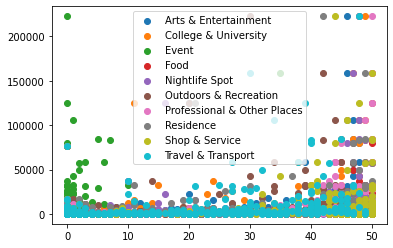

In [ ]:
#Quick exploratory analysis to see if a relationship exists
for item, value in Airporttraffic.iloc[:,8:].iteritems():
  quick=plt.scatter(Airporttraffic[item], Airporttraffic['Total Traffic'], label=item)

plt.legend()

In [ ]:
# running regression analysis with statsmodels
import statsmodels.api as sm

indep2 = Airporttraffic.iloc[:,8:]
dep2 = Airporttraffic['Total Traffic']

indep2 = sm.add_constant(indep2) # adding a constant
 
model2 = sm.OLS(dep2, indep2.astype(float)).fit()

print_model2 = model2.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:          Total Traffic   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     14.67
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           2.16e-21
Time:                        19:34:31   Log-Likelihood:                -3633.5
No. Observations:                 325   AIC:                             7289.
Df Residuals:                     314   BIC:                             7331.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
pvalues=pd.DataFrame(model2.pvalues, columns={'pvalue'})
pvalues.reset_index(inplace=True)
pvalues.sort_values(by='pvalue', axis=0, ascending=True, inplace=True, ignore_index=True)
pvalues

index        pvalue
0                         Event  1.824105e-18
1            Travel & Transport  2.062349e-05
2                     Residence  5.697163e-03
3         Outdoors & Recreation  6.702159e-02
4   Professional & Other Places  8.419655e-02
5                Shop & Service  1.318703e-01
6                Nightlife Spot  2.638934e-01
7                          Food  3.271055e-01
8                         const  3.547974e-01
9          College & University  4.607192e-01
10         Arts & Entertainment  9.276207e-01

In [ ]:
#@title
# we will rerun the analysis using eliminating the inconsequent rows
indep2 = Airporttraffic.iloc[:,8:].drop(columns=(pvalues['index'][[9,7,6,5,2,4,10,3,1]]))
dep2 = Airporttraffic['Total Traffic']

indep2 = sm.add_constant(indep2) # adding a constant
 
model2 = sm.OLS(dep2, indep2.astype(float)).fit()

print_model2 = model2.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:          Total Traffic   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     99.60
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.27e-20
Time:                        19:36:04   Log-Likelihood:                -3652.1
No. Observations:                 325   AIC:                             7308.
Df Residuals:                     323   BIC:                             7316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5450.8640   1046.241      5.210      0.0